<img src ="https://mms.businesswire.com/media/20190513005309/en/721184/5/PSA_LOGO.jpg" width = 550>

Pitstop arabia is an online tyre ordering service. You order the tyre online, they purchase it and direct you to one of their locations for it to be installed. I have aquiered data pertaining to the sales of the tyres themselves and the installer locations.

The goal of this project is to predict how many tyres a location may need, so that they can predict the type of stock they'd need for any time during the yer (or at least a few months ahead of time) 

Let's start by importing our standard libraries, as well as some tools from sklearn and statsmodels: 



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore') #Not recommended, but saves headache. 

And read in the data: 

In [3]:
tyres = pd.read_csv("tire_data/tyre_data_analysis.csv")

print("Size of the data set: ", tyres.shape)

Size of the data set:  (2574, 24)


In [4]:
tyres.sample(n=5)

,Order Date,Order #,Order Status,Service Date,Installer Name,Installer Address,Installer City,Vehicle Reg,Vehicle Make,Vehicle Model,...,QTY Ordered,width,height,rim size,year,Subtotal,Shipping & Handling,Discount,Tax Amount,Grand Total
406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,225,40,19,2018.0,NaN,NaN,NaN,NaN,NaN
2073,16-06-17 10:10,100002955.0,complete,17-06-17,ZDegree,"Enoc Petrol Pump, Next To Al Waha St Exit, \r\...",Dubai,38546,kia,sportage,...,1,NaN,NaN,NaN,NaN,396.0,0.0,0.0,0.0,396.0
388,11/7/2016 5:57,100000710.0,complete,14-07-16,FirstStop,Khalifa city,Abu Dhabi,89325,mercedes,gl-class,...,4,NaN,NaN,NaN,NaN,4436.0,0.0,-443.6,0.0,3992.4
39,10/2/2016 17:31,100000274.0,complete,11/2/2016,ZDegree,"Hessa - ENOC Petrol Station, Al Khail Rd, \r\n...",Dubai,81157,honda,civic,...,4,205,55,16,2020.0,828.0,0.0,0.0,0.0,828.0
356,27-06-16 11:20,100000673.0,complete,29-06-16,ZDegree,"Hessa - ENOC Petrol Station, Al Khail Rd, \r\n...",Dubai,c70166,porsche,911,...,2,235,35,19,2019.0,5576.0,0.0,-400.0,0.0,5176.0


# Dropping Unecessary Columns
Time series analysis needs only 2 compoennts, time and the qunaitity to predict. I also plan to use lcoation to split this data into chunks, so keeping the address is a must. everything else is unecessary for this problem. We can also see what type of information we have on the tyres themselvs:


In [4]:
pd.DataFrame(tyres.columns) #Done to make it look nicer

,0
0,Order Date
1,Order #
2,Order Status
3,Service Date
4,Installer Name
5,Installer Address
6,Installer City
7,Vehicle Reg
8,Vehicle Make
9,Vehicle Model


In [5]:
drop_columns = ['Installer Name',
                'Vehicle Reg',
                'Vehicle Make',
                'Vehicle Model',
                'Vehicle Year ',
                'SKU',
                'Brand',
                'Name',
                'width',
                'height',
                'rim size',
                'year',
                'Shipping & Handling ',
                'Discount',
                'Tax Amount',
                'Order Status']
tyres.drop(drop_columns, axis = 1, inplace = True)

In [6]:
tyres.head()

,Order Date,Order #,Service Date,Installer Address,Installer City,QTY Ordered,Subtotal,Grand Total
0,2/1/2016 13:01,100000225.0,4/1/2016,"Hessa - ENOC Petrol Station, Al Khail Rd, \r\n...",Dubai,4,3588.0,3588.0
1,4/1/2016 16:15,100000230.0,6/1/2016,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,4,2396.0,2396.0
2,4/1/2016 18:17,100000231.0,6/1/2016,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,2,998.0,998.0
3,5/1/2016 10:21,100000233.0,8/1/2016,"Shk Mohd Bin Zd Rd, E 311, -Inside Enoc Fuel S...",Dubai,2,870.0,870.0
4,7/1/2016 17:22,100000235.0,16-01-16,"behind Honda Showroom / Oasis Centre , Opposit...",Dubai,2,3752.0,3752.0


# Fixing 2nd tyre order issue

Sometimes, a customer has different tyres in the back and front, prompting them to buy 2 sets of tyres. When that happens a new row is added and the information about the second tire is added to the next row, but everything else is blank. Let's take a look at an example of a second tyre order, say row 5: 

In [7]:
tyres.iloc[5,:]

Order Date           NaN
Order #              NaN
Service Date         NaN
Installer Address    NaN
Installer City       NaN
QTY Ordered            2
Subtotal             NaN
Grand Total          NaN
Name: 5, dtype: object

It would be a shame to simply throw this data away. One way to keep it is to tie it back to the customer. The customer is located in the previous row, making this very easy to append.

In [8]:
null_index = tyres[tyres['Order #'].isna() == True].index
t_columns = ['Order Date', 'Order #', 'Service Date',
       'Installer Address', 'Installer City', 'Subtotal ',
       'Grand Total']


for i in null_index: #For every null row
    for col in t_columns: #for every column
        tyres.loc[i,col] = tyres.loc[i-1,col] #make the previous order info the same, except for the QTY ordered

In [9]:
tyres.head(6) #Take a look at row 5, the previous null row!

,Order Date,Order #,Service Date,Installer Address,Installer City,QTY Ordered,Subtotal,Grand Total
0,2/1/2016 13:01,100000225.0,4/1/2016,"Hessa - ENOC Petrol Station, Al Khail Rd, \r\n...",Dubai,4,3588.0,3588.0
1,4/1/2016 16:15,100000230.0,6/1/2016,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,4,2396.0,2396.0
2,4/1/2016 18:17,100000231.0,6/1/2016,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,2,998.0,998.0
3,5/1/2016 10:21,100000233.0,8/1/2016,"Shk Mohd Bin Zd Rd, E 311, -Inside Enoc Fuel S...",Dubai,2,870.0,870.0
4,7/1/2016 17:22,100000235.0,16-01-16,"behind Honda Showroom / Oasis Centre , Opposit...",Dubai,2,3752.0,3752.0
5,7/1/2016 17:22,100000235.0,16-01-16,"behind Honda Showroom / Oasis Centre , Opposit...",Dubai,2,3752.0,3752.0


Finally, let's see how many null values we have to fill:

In [10]:
tyres.isna().sum()

Order Date           0
Order #              0
Service Date         0
Installer Address    9
Installer City       0
QTY Ordered          0
Subtotal             0
Grand Total          0
dtype: int64

In [11]:
#Simply use a forward fill

tyres.loc[:,'Installer Address'].ffill(inplace = True)

tyres.isna().sum()

Order Date           0
Order #              0
Service Date         0
Installer Address    0
Installer City       0
QTY Ordered          0
Subtotal             0
Grand Total          0
dtype: int64

Excellent! We retained the data, and filled in the gaps! Now let's work on converting it to the data types we need. 

## Quick Tweaks
Some columns don't have the correct data type, and some columns have weird values. Let's see what they are currently: 

In [12]:
tyres.dtypes

Order Date            object
Order #              float64
Service Date          object
Installer Address     object
Installer City        object
QTY Ordered            int64
Subtotal             float64
Grand Total          float64
dtype: object

Let's solve this problem row by row, we'll begin with the order date: 

In [13]:
tyres.loc[:,"Order Date"] = pd.to_datetime(tyres.loc[:,"Order Date"]) #Order Date (date time)

tyres.loc[:,"Service Date"] = pd.to_datetime(tyres.loc[:,"Service Date"]) #Service Date (date time)

#They were also out of order, so I sort them here: 
tyres.sort_values(by = 'Order Date', inplace = True);

tyres = tyres[tyres['QTY Ordered'] <= 10] #Outrageous tyre purchases are few and far between, I get rid of them here. 
#I Chose 10 because I see one scenario of a couple with matching jeeps (4 tyres + spare tyre in back)

In [14]:
tyres.reset_index(inplace = True) #Resetting the index since the sorting jumbled it up
tyres.drop('index',axis = 1, inplace = True) #Dropping the old index

tyres['QTY Ordered'].sort_values() #Take a look at the maximum values, maybe a semi-truck or couple with matching VW's?

1955    1
175     1
345     1
2060    1
2059    1
       ..
562     5
977     5
736     5
959     8
1275    8
Name: QTY Ordered, Length: 2572, dtype: int64

Excellent! You'll have noticed that I kept some features that may not seem relevant to the time series analysis. This is because I plan to do more as time goes on and I have a chance to do some more analysis on the data, but the focus for this project is the analysis. I keep them because it has a negligable effect on the speed of training and testing, so there is no harm keeping them around. 

Now that that is explained, we can move on to teh location grouping. 

## Locations
Now for the addresses, one of the most important parts. What I am predicting, is what amount of tires would be needed in what locations on what day. However, locations vary in popularity meaning data is not plentiful for most of them. Below is the plotted usage of each of the locations: 

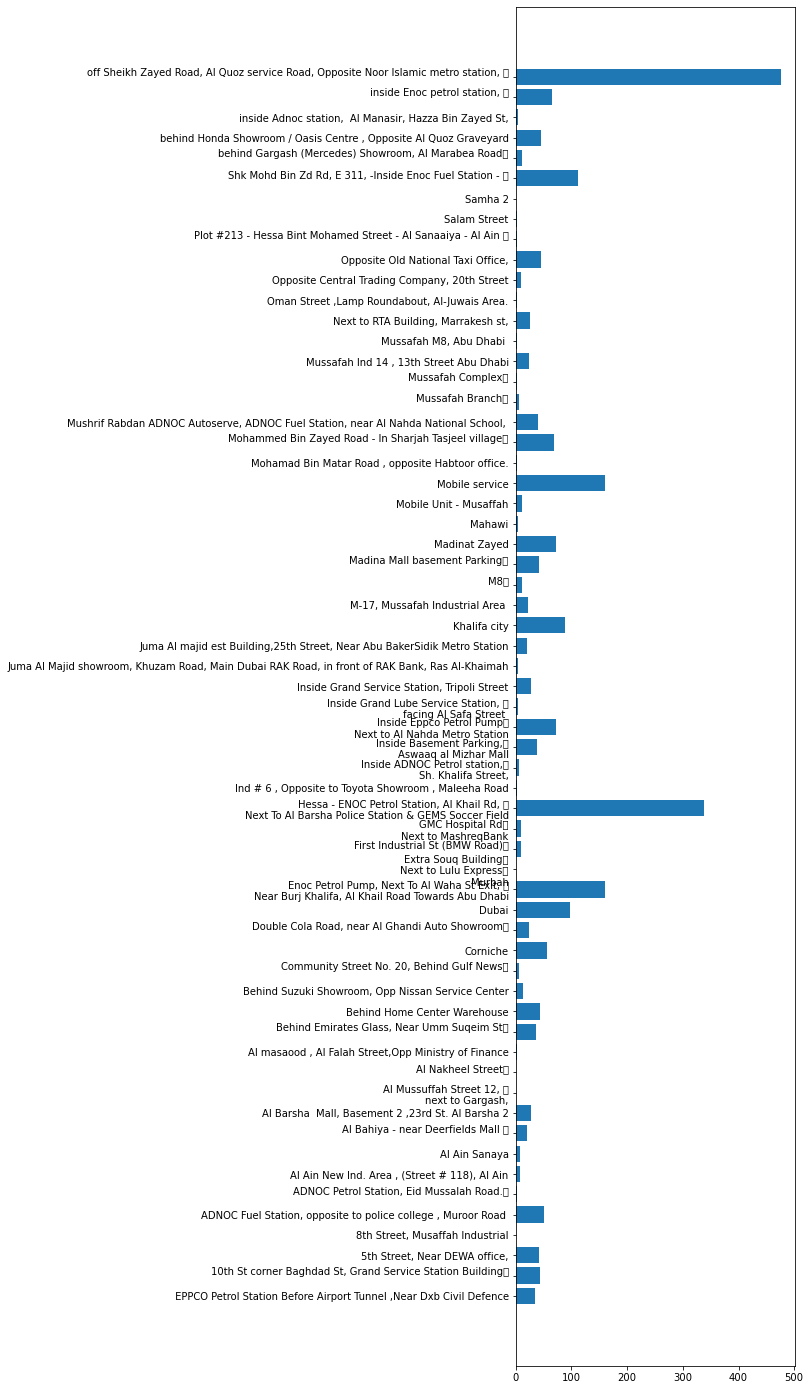

In [15]:
grouped_locations = tyres.groupby("Installer Address")["QTY Ordered"].count() #Group counts
grouped_locations = pd.DataFrame(grouped_locations) #Convert to DF
grouped_locations.reset_index(inplace = True) #Reset the index

#Ready for plotting!

plt.figure(figsize = (5,25))
plt.barh(grouped_locations['Installer Address'], grouped_locations['QTY Ordered'])
plt.show()

A much simpler approach would be group these locations together for plotting. We will need both the latitude and longitude of each location in order to make appropriate bounds.

Normally, I would use the google API to exchange the adress for the coordinates, however Dubai (and the middle east in general) has a problem with formal addressess, they don't really have any. Take a look at some of these "Addressess"

* behind Honda Showroom / Oasis Centre , Opposite Al Quoz Graveyard
* Oman Street ,Lamp Roundabout, Al-Juwais Area.
* ADNOC Fuel Station, opposite to police college , Muroor Road
* Behind Emirates Glass, Near Umm Suqeim St
* Next to RTA Building, Marrakesh st,

This can not be submitted to the google API.

During my time in Saudi Arabia, there were addressess, but many were not formally recorded (*more of a decoration than anything else*). 
It wasn't until [2010](https://www.esri.com/news/arcnews/winter1011articles/saudi-arabia.html#:~:text=Traditionally%2C%20home%20and%20street%20addresses,directly%20from%20the%20post%20office.) in Saudi Arabia and [2015](https://www.citymetric.com/horizons/buildings-dubai-and-abu-dhabi-didnt-have-official-addresses-thats-finally-changing-838) in the United Arab Emirates that postal codes and the like started to emerge. It still isn't the most robust system, and many rely on landmaks like "the Emirates Mall" or "the gas station next to the Burj Khalifa" for addressess. 

Take a look at line 10 in the next code block, and you can see a prime example of an "address" in the UAE. 

This lead to the (painfully) manual process of going through google maps for all 61 unique locations. Please enjoy my work below: 

In [16]:
#add_coo == Address Coordinates

add_coo = {} #Dictionary associating each location with their respective lattitude and longitude
add_coo['Hessa - ENOC Petrol Station, Al Khail Rd, \r\nNext To Al Barsha Police Station & GEMS Soccer Field'] = (25.066277, 55.218215)
add_coo[' \r\nNext To Al Barsha Police Station & GEMS Soccer Field'] = (25.080584, 55.215431)
add_coo['Al Barsha  Mall, Basement 2 ,23rd St. Al Barsha 2'] = (25.098187, 55.203553)
add_coo['Shk Mohd Bin Zd Rd, E 311, -Inside Enoc Fuel Station - \r\n'] = (25.059133, 55.285133)
add_coo['behind Honda Showroom / Oasis Centre , Opposite Al Quoz Graveyard'] = (25.168575, 55.241198)
add_coo['Dubai'] = (25.152925, 55.262578)
add_coo['inside Enoc petrol station, \r\n'] = (25.150143, 55.244540)
add_coo['10th St corner Baghdad St, Grand Service Station Building\r\n'] = (25.199583, 55.441530)
add_coo['Behind Suzuki Showroom, Opp Nissan Service Center'] = (25.259433, 55.334238)
add_coo['Next to RTA Building, Marrakesh st,'] = (25.233531, 55.356299)
add_coo['Inside Grand Service Station, Tripoli Street'] = (25.199680, 55.441432)
add_coo['M-17, Mussafah Industrial Area '] = (24.364980, 54.491010)
add_coo['Enoc Petrol Pump, Next To Al Waha St Exit, \r\nNear Burj Khalifa, Al Khail Road Towards Abu Dhabi'] = (25.211362, 55.259310)
add_coo['Khalifa city'] = (24.405996, 54.602742)
add_coo['Corniche'] = (25.256534, 55.306121)
add_coo['Behind Emirates Glass, Near Umm Suqeim St\r\n'] = (25.114569, 55.222304)
add_coo['Al masaood , Al Falah Street,Opp Ministry of Finance'] = (24.485140, 54.378802)
add_coo['Salam Street'] = (24.413092, 54.503905)
add_coo['Opposite Central Trading Company, 20th Street'] = (25.129721, 55.245257)
add_coo['Plot #213 - Hessa Bint Mohamed Street - Al Sanaaiya - Al Ain \r\n'] = (24.213164, 55.760262)
add_coo['Inside Grand Lube Service Station, \r\nfacing Al Safa Street '] = (25.207087, 55.268465)
add_coo['behind Gargash (Mercedes) Showroom, Al Marabea Road\r\n'] = (25.130630, 55.219551)
add_coo['Mobile Unit - Musaffah'] = (24.346592, 54.487272)
add_coo['Juma Al majid est Building,25th Street, Near Abu BakerSidik Metro Station'] = (25.270249, 55.326704)
add_coo[' EPPCO Petrol Station Before Airport Tunnel ,Near Dxb Civil Defence'] = (25.267141, 55.355484)
add_coo['Inside ADNOC Petrol station,\r\nSh. Khalifa Street,'] = (24.499881, 54.368962)
add_coo['First Industrial St (BMW Road)\r\n'] = (25.320569, 55.401860)
add_coo['Madinat Zayed'] = (23.666361, 53.695055)
add_coo['ADNOC Fuel Station, opposite to police college , Muroor Road '] = (24.436862, 54.422066)
add_coo['Opposite Old National Taxi Office,'] = (25.115186, 55.220820)
add_coo['Samha 2'] = (24.671022, 54.759717)
add_coo['M8\r\n'] = (25.286304, 55.478272)
add_coo['Mohamad Bin Matar Road , opposite Habtoor office.'] = (25.166264, 55.225182)
add_coo['Mahawi'] = (24.349637, 54.584522)
add_coo['Mussafah Branch\r\n'] = (24.377345, 54.497503)
add_coo['Double Cola Road, near Al Ghandi Auto Showroom\r\n'] = (25.332196, 55.470854)
add_coo['Inside Eppco Petrol Pump\r\nNext to Al Nahda Metro Station'] = (25.274270, 55.368493)
add_coo['off Sheikh Zayed Road, Al Quoz service Road, Opposite Noor Islamic metro station, \r\n'] = (25.154543, 55.228176)
add_coo['Mobile service'] = (24.5, 54.3) #####981234798012374089271940892314
add_coo['Juma Al Majid showroom, Khuzam Road, Main Dubai RAK Road, in front of RAK Bank, Ras Al-Khaimah'] = (25.707212, 55.970226)
add_coo['Mohammed Bin Zayed Road - In Sharjah Tasjeel village\r\n'] = (25.343653, 55.473574)
add_coo['Madina Mall basement Parking\r\n'] = (25.281752, 55.398280)
add_coo['Inside Basement Parking,\r\nAswaaq al Mizhar Mall'] = (25.246192, 55.452685)
add_coo['Al Mussuffah Street 12, \r\nnext to Gargash,'] = (24.360125, 54.504070)
add_coo['Mussafah Ind 14 , 13th Street Abu Dhabi'] = (24.330692, 54.533828)
add_coo['Al Ain Sanaya'] = (24.179849, 55.762638)
add_coo['Oman Street ,Lamp Roundabout, Al-Juwais Area.'] = (25.769444, 55.974937)
add_coo['Al Ain New Ind. Area , (Street # 118), Al Ain'] = (24.220467, 55.758508)
add_coo['ADNOC Petrol Station, Eid Mussalah Road.\r\n'] = (24.239734, 55.696923)
add_coo['Behind Home Center Warehouse'] = (25.144578, 55.230620)
add_coo['GMC Hospital Rd\r\nNext to MashreqBank'] = (25.382247, 55.462849)
add_coo['Community Street No. 20, Behind Gulf News\r\n'] = (25.258551, 55.321747)
add_coo['Mushrif Rabdan ADNOC Autoserve, ADNOC Fuel Station, near Al Nahda National School, '] = (24.436508, 54.402399)
add_coo['Ind # 6 , Opposite to Toyota Showroom , Maleeha Road'] = (25.333723, 55.399324)
add_coo['Al Bahiya - near Deerfields Mall \r\n'] = (24.521642, 54.669278)
add_coo['Mussafah Complex\r\n'] = (24.515570, 54.661096)
add_coo['Extra Souq Building\r\nNext to Lulu Express\r\nMurbah'] = (25.282827, 56.355189)
add_coo['5th Street, Near DEWA office,'] = (25.227026, 55.323806)
add_coo['inside Adnoc station,  Al Manasir, Hazza Bin Zayed St,'] = (24.456902, 54.356534)
add_coo['Mussafah M8, Abu Dhabi '] = (24.379093, 54.512613)
add_coo['8th Street, Musaffah Industrial'] = (24.373577, 54.487804)
add_coo['Al Nakheel Street\r\n'] = (24.448178, 54.398642)

Now, I'll add the lattitude and longitude values as new columns in the data frame. 

In [17]:
tyres['Lattitude'] = 0 #adding empty 0 values to it
tyres['Longitude'] = 0 #Same as above

for i in range(len(tyres['Lattitude'])):
    address = tyres.loc[i,'Installer Address'] #Getting the address
    tyres.loc[i,'Lattitude'] = add_coo[address][0] #Adding lattitude to that row
    tyres.loc[i,'Longitude'] = add_coo[address][1] #Adding Longitude to that row

Now I'll plot them onto the map of the UAE

In [18]:
#Using these values to get the Bounding Box (BBox) which will get me the map I need to plot points on the correct spot
min_lat = tyres['Lattitude'].min()
max_lat = tyres['Lattitude'].max()

min_lng = tyres['Longitude'].min()
max_lng = tyres['Longitude'].max()

BBox = ((min_lng, max_lng,      
         min_lat, max_lat))

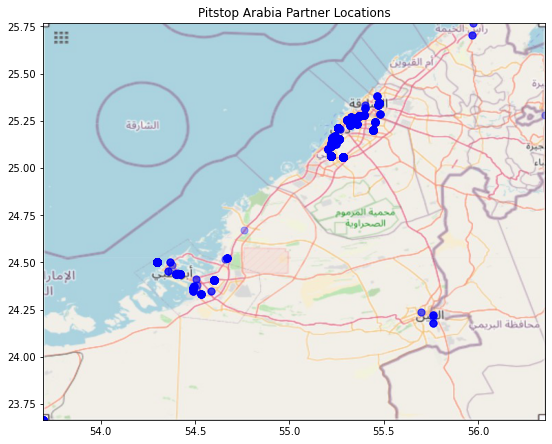

In [19]:
#Code here not to important, focus on map please. 
ruh_m = plt.imread('maps/uae_map.jpg')

fig, ax = plt.subplots(figsize = (9,9))
ax.scatter(tyres['Longitude'], tyres['Lattitude'], c='b', s=50, alpha = 0.3)
ax.set_title('Pitstop Arabia Partner Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

I can see from the map that the vast majority of the installations happen in both Dubai and Abu Dhabi, and the rest of the cities don't have enough influence to be considered a major part of the model.

## Splitting the cities
I will split Abu Dhabi and Dubai into chunks, and make the rest of the cities there own chunk. I will then have a few groups, and I can fit a few models to predict the demand in each one. 

In [20]:
#1. Get the cties into their own dataframes
dubai = tyres[tyres['Installer City'] == 'Dubai']
abu_dhabi = tyres[tyres['Installer City'] == 'Abu Dhabi']
third_chunk = tyres[(tyres['Installer City'] != 'Abu Dhabi') & (tyres['Installer City'] != 'Dubai')]

#Sort the values by order dates
dubai = dubai.sort_values(by = 'Order Date')
abu_dhabi = abu_dhabi.sort_values(by = 'Order Date')
third_chunk = third_chunk.sort_values(by = 'Order Date')

#reset the index and drop the old index. 
dubai = dubai.reset_index().drop('index', axis = 1)
abu_dhabi = abu_dhabi.reset_index().drop('index', axis = 1)
third_chunk = third_chunk.reset_index().drop('index', axis = 1)

### Dubai

In [21]:
#Plotting Dubai first by getting its bounding box
min_lat = dubai['Lattitude'].min()
max_lat = dubai['Lattitude'].max()

min_lng = dubai['Longitude'].min()
max_lng = dubai['Longitude'].max()

BBox = ((min_lng, max_lng,      
         min_lat, max_lat))
print(min_lng, max_lng, min_lat, max_lat)

54.3 55.452685 24.5 25.281752


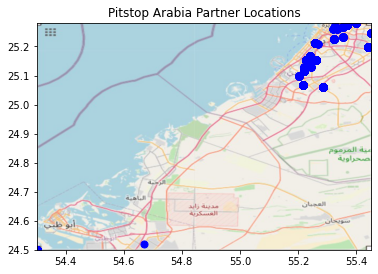

In [22]:
ruh_m = plt.imread('maps/dubai_map.jpg')

fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(dubai['Longitude'], dubai['Lattitude'], c='b', s=50)
ax.set_title('Pitstop Arabia Partner Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

we see 2 very distinct sections of upper dubai and lower Dubai. Those locatons need to be seperated because of their distance. We could very easily draw a line in the center (Lattititude = 24.8) and say that everyone whose `latitude > 24.8 = Upper Dubai, else Lower Dubai`

In [23]:
dubai['Section'] = 'dubai'

for i in range(len(dubai['Lattitude'])):
    if dubai.loc[i,'Lattitude'] > 24.8:
        dubai.loc[i,'Section'] = 'Upper Dubai'
    else:
        dubai.loc[i,'Section'] = 'Lower Dubai'

In [24]:
u_dubai = dubai[dubai['Section'] == 'Upper Dubai']
u_dubai = u_dubai.reset_index().drop('index', axis = 1)

l_dubai = dubai[dubai['Section'] == 'Lower Dubai']
l_dubai = l_dubai.reset_index().drop('index', axis = 1)

### Abu Dhabi

In [25]:
#Plotting Dubai first: 
min_lat = abu_dhabi['Lattitude'].min()
max_lat = abu_dhabi['Lattitude'].max()

min_lng = abu_dhabi['Longitude'].min()
max_lng = abu_dhabi['Longitude'].max()

BBox = ((min_lng, max_lng,      
         min_lat, max_lat))
print(min_lng, max_lng, min_lat, max_lat)

53.695055 55.478272 23.666361 25.286304


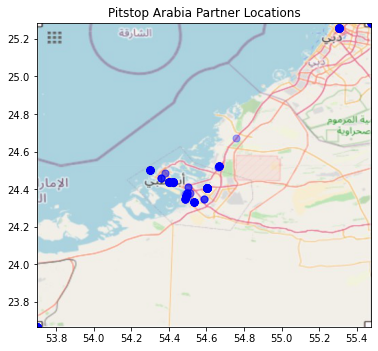

In [26]:
ruh_m = plt.imread('maps/abu_dhabi_map.jpg')

fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(abu_dhabi['Longitude'], abu_dhabi['Lattitude'], c='b', s=50, alpha = 0.3)
ax.set_title('Pitstop Arabia Partner Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

Abu Dhabi doens't seem to have its own distinct sections. It can be left alone.

## Choosing  model
We now have our split cities! Let's try and fit a model on top to get an idea as to what needs to happen with other chunks: 

In [27]:
from statsmodels.tsa.ar_model import AR #The model of choice

train_percentage = 0.7
train_size = int(round(len(tyres['Order Date']),0) * train_percentage)
train = tyres.loc[0:train_size,['QTY Ordered','Order Date']]

test_size = len(tyres['Order Date']) - train_size
test = tyres.loc[train_size : train_size + test_size,['QTY Ordered','Order Date']]

### Auto Regression Model
Now the auto regression model is very similiar to the linear regression, in so far as it usues the same $y = mx + b$ format. Except, it uses the previous entry as its new predictor.

To evaluate the model, I originally used a simple accuracy score (see how many it had gotten correct) which is NOT the way to do it. You need the Root Mean Sqaure Error given by the following formula: 

<img src = "https://www.includehelp.com/ml-ai/Images/rmse-1.jpg" width = 300>

A good RMSE value will be approximatley [0.7](https://stats.stackexchange.com/questions/56302/what-are-good-rmse-values) for dataset that are ~1000 large. This is a rough estimate, but anything around there should indicate a competent model. 

I did keep score however, simply because it's comforting to see some percentages. Score may be the metric for many other models, but time series data is not alway like that. An exact answer is not expected, like in the case of stock prices. One simply want to see if it will be larger or smaller than last value to make a profit. 

Will end at 1441
Current best lag:20 with error: 1.2649110640673518
Current best lag:360 with error: 1.1832159566199232
Current best lag:640 with error: 1.0954451150103321
Current best lag:1200 with error: 1.0488088481701516
28.46%


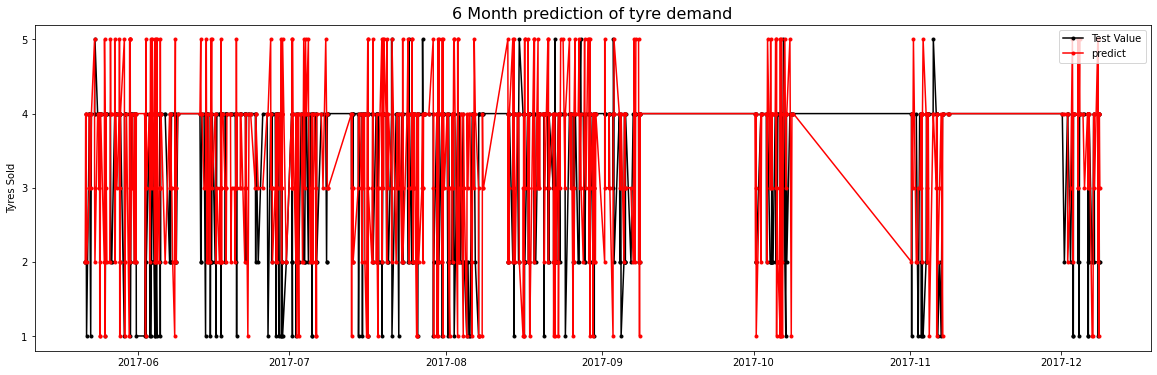

In [28]:
max_lag = int(round(train.shape[0]*0.8,0)) #maximum days to look back at for refrence
lags = range(20,max_lag,10)
lag_dict = {} #Keeping track of the lags and their errors
best_error = np.inf

print(f"Will end at {max_lag}")

##########################################################################################

###FIRST, OPTIMIZE THE MODEL###

for lag in lags:
    #Instantiating the model and optimizing it. 
    model = AR(train['QTY Ordered'])
    model_fit = model.fit(maxlag=lag)


    #Making the predictions and making sure they have the appropriate date
    predictions = round(model_fit.predict(start=train_size, end=train_size+test_size),0)
    predictions = pd.DataFrame(predictions)
    predictions.columns = ['QTY Ordered']
    predictions['Order Date'] = test['Order Date']


    #Ensuring reasonable values are predicted
    for j in predictions.index:
        if predictions.loc[j,'QTY Ordered'] > 5 or predictions.loc[j,'QTY Ordered'] < 1: 
            predictions.loc[j,'QTY Ordered'] = train['QTY Ordered'].mode()[0]
    
    
    #Getting the error throught the mean square test: 
    error = np.sqrt(mean_squared_error(test['QTY Ordered'][:10], predictions['QTY Ordered'][:10]))
    lag_dict[lag] = error
    if error < best_error: 
        best_error = error
        lag_dict[error] = lag
        print(f"Current best lag:{lag} with error: {error}")
    
            
    print(lag, end = '\r')  

#############################################################################################################

###INSERTING THE BEST HYPER PARAMETER###

#Instantiating the model and optimizing it. 
model = AR(train['QTY Ordered'])
model_fit = model.fit(maxlag=lag_dict[best_error])

#Making the predictions and making sure they have the appropriate date
predictions = round(model_fit.predict(start=train_size, end=train_size+test_size),0)
predictions = pd.DataFrame(predictions)
predictions.columns = ['QTY Ordered']
predictions['Order Date'] = test['Order Date']


#Ensuring reasonable values are predicted (values <= 0 or extremly large tyre purcahses are changed to the mode)
for j in predictions.index:
    if predictions.loc[j,'QTY Ordered'] > 5 or predictions.loc[j,'QTY Ordered'] < 1: 
        predictions.loc[j,'QTY Ordered'] = train['QTY Ordered'].mode()[0]

#Scoring (For reference, not for choosing a model)
point = 0
for i in range(len(test)):
    if list(test['QTY Ordered'])[i] == list(predictions['QTY Ordered'])[i]:
        point+=1
score = point / len(predictions)
print(f"{round(score*100,2)}%")

#Plotting
plt.figure(figsize = (20,6))
plt.title("6 Month prediction of tyre demand",size = 16)
plt.plot(test['Order Date'], test['QTY Ordered'], c="black", label="Test Value", marker='.')
plt.plot(predictions['Order Date'], predictions['QTY Ordered'], c="red", label="predict", marker='.')
plt.ylabel("Tyres Sold")
plt.yticks(range(1,6,1))
plt.xticks()
plt.legend()
plt.show();

Not a bad result. After about a month or so, it doesn't seem to be as accurate and decays off towards 3.  Let's now take a look at the Moving Average model: 

### Moving Average
The moving average is exactly as it sounds, take the current stock price, birth rate, tyres sold, etc. and update its average as more time passes and data is added. 

We call it by usuing `SARIMAX`, which also has a way to integrate the previous model (autoregression) and combine it with moving average. For this demo, we will only use moving average. 


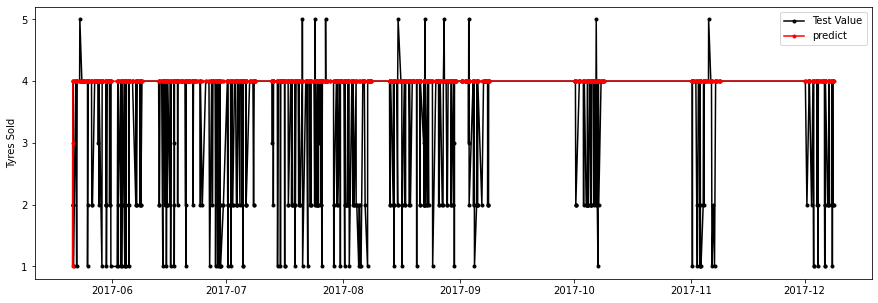

Error: 1.5491933384829668
Score: 63.78%


In [29]:
#Instantiating the model
model = SARIMAX(train['QTY Ordered'], order=(0, 0, 5)) # order of 0 for AR, 0 for integrated component 
                                        # and order of 5 for MA
model_fit = model.fit()


#Making the predictions and making sure they have the appropriate date
predictions = round(model_fit.predict(start=train_size, end=train_size+test_size),0)
predictions = pd.DataFrame(predictions)
predictions.columns = ['QTY Ordered']
predictions['Order Date'] = test['Order Date']


#Ensuring reasonable values are predicted
for j in predictions.index:
    if predictions.loc[j,'QTY Ordered'] > 5 or predictions.loc[j,'QTY Ordered'] < 1: 
        predictions.loc[j,'QTY Ordered'] = 4

#Plotting
plt.figure(figsize = (15,5))
plt.plot(test['Order Date'], test['QTY Ordered'], c="black", label="Test Value", marker='.')
plt.plot(predictions['Order Date'], predictions['QTY Ordered'], c="red", label="predict", marker='.')
plt.ylabel("Tyres Sold")
plt.yticks(range(1,6,1))
plt.xticks()
plt.legend()
plt.show();

#Scoring 
error = np.sqrt(mean_squared_error(test['QTY Ordered'][:10], predictions['QTY Ordered'][:10]))
print(f"Error: {error}")

#Scoring based on correct predictions (for refrence, not for choosing model)
point = 0
for i in range(len(test)):
    if list(test['QTY Ordered'])[i] == list(predictions['QTY Ordered'])[i]:
        point+=1
score = point / len(predictions)
print(f"Score: {round(score*100,2)}%")

This one isn't great, it ends up choosing 4 for infinity after only a few entries. Despite this, it ends up with a *very* imporessive 64%, and you learn quickly why plain accuracy is not the best metric. Let's try and find the ideal combination of them:

### ARMA or ARIMA
This model combines both of the previous model. It has 3 terms: 
* The degree of using the Auto Regression
* The integration factor used to reduce seasonality
* The degree of using the Moving Average

In [30]:
best_error = np.inf

p_range = range(10)
q_range = range(10)
d_range = [0, 1, 2]

error_dict = {}

# loop over hyper parameters
for p in p_range:
    for d in d_range:
        for q in q_range:
            print(f"Working on p={p}, d={d}, q={q}...", end="\r")
            # define and fit the model
            model = SARIMAX(train['QTY Ordered'], 
                            order=(p, d, q), 
                            enforce_stationarity=False, 
                         
                            trend="t") # order of p for AR, d differentiation, and q for MA

            model_fit = model.fit(maxiter=2000)

            # make prediction and evaluate
            predictions = round(model_fit.predict(start=train_size, end=train_size+test_size),0)
            predictions = pd.DataFrame(predictions)
            predictions.columns = ['QTY Ordered']
            predictions['Order Date'] = test['Order Date']
            error = np.sqrt(mean_squared_error(test['QTY Ordered'][:10], predictions['QTY Ordered'][:10]))

            # print if we have the new best error and update best error
            error_dict[(p, d, q)] = error
            if error < best_error:
                print(f"Best error {(p, d, q)}: ", error)
                best_error = error

Best error (0, 0, 0):  2.5298221281347035
Best error (0, 0, 1):  2.32379000772445
Best error (0, 0, 2):  2.1447610589527217
Best error (0, 0, 3):  2.1213203435596424
Best error (0, 0, 4):  1.9493588689617927
Best error (0, 0, 8):  1.6733200530681511
Best error (0, 1, 0):  1.61245154965971
Best error (0, 1, 1):  1.378404875209022
Best error (0, 1, 3):  1.2649110640673518
Best error (0, 2, 3):  1.224744871391589


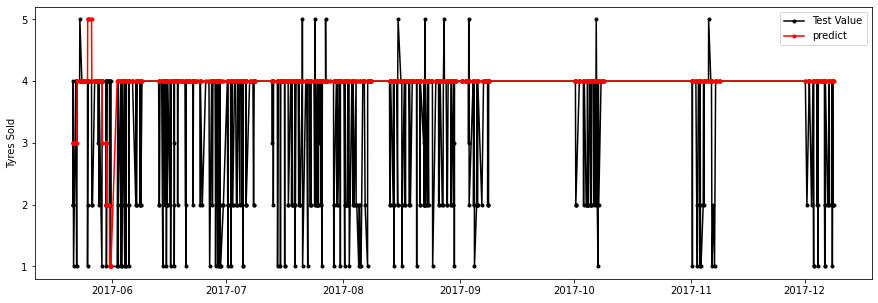

Score: 60.93%


In [31]:
#Instantiating the model and optimizing it. 
model = SARIMAX(train['QTY Ordered'], 
                      order=(0, 2, 3), #Apparently the best moving average is no moving average (in this case) 
                      enforce_stationarity=False,  
                      trend="t") # order of p for AR, d differentiation, and q for MA

model_fit = model.fit(maxiter=2000)


#Making the predictions and making sure they have the appropriate date
predictions = round(model_fit.predict(start=train_size, end=train_size+test_size),0)
predictions = pd.DataFrame(predictions)
predictions.columns = ['QTY Ordered']
predictions['Order Date'] = test['Order Date']


#Ensuring reasonable values are predicted
for j in predictions.index:
    if predictions.loc[j,'QTY Ordered'] > 5 or predictions.loc[j,'QTY Ordered'] < 1: 
        predictions.loc[j,'QTY Ordered'] = 4

#Plotting
plt.figure(figsize = (15,5))
plt.plot(test['Order Date'], test['QTY Ordered'], c="black", label="Test Value", marker='.')
plt.plot(predictions['Order Date'], predictions['QTY Ordered'], c="red", label="predict", marker='.')
plt.ylabel("Tyres Sold")
plt.yticks(range(1,6,1))
plt.xticks()
plt.legend()
plt.show();


#Scoring
point = 0
for i in range(len(test)):
    if list(test['QTY Ordered'])[i] == list(predictions['QTY Ordered'])[i]:
        point+=1
score = point / len(predictions)
print(f"Score: {round(score*100,2)}%")

This one did ok, but not nearly as well as the Auto regression and it took a VERY long time to actually train. That's why, the Auto Regression will be my model of choice. 

## Creating the function 
While I could use ML piplines, I don't have the full understanding of how to use it yet. It would also be much easier for me to explain the function itself.

In [32]:
def pitstop_AR(train_pctg, c_val_pctg, data_frame,title):
    from statsmodels.tsa.ar_model import AR #The model of choice
    
    train_percentage = train_pctg
    c_val_percentage = c_val_pctg
    
    df = data_frame.sort_values(by = "Order Date") #Ensureing values are sorted before any modeling happens
    
    train_size = int(round(len(df['Order Date']),0) * train_percentage) #Getting a number from the percentage
    train = df.loc[0:train_size,['QTY Ordered','Order Date']] #Getting the rows with said number

    c_val_size = int(round(len(df['Order Date']),0) * c_val_percentage) #Getting a number from the percentage
    c_val = df.loc[train_size : train_size + c_val_size,['QTY Ordered','Order Date']] #Getting the rows with said number

    test = df.loc[train_size + c_val_size: len(df)-1,['QTY Ordered','Order Date']] #rest of the rows are used for testing
    test_size = len(test)
    print(f"{100*round(1-train_pctg - c_val_pctg,2)}% or {len(test['QTY Ordered'])} rows will be used for testing.")

    
    
####################################################################################################################

    #Hyper Parameter Optimization
    max_lag = int(train.shape[0] * 0.8) #looking back at the past 80% of values. 
    lag_values = range(2, max_lag, 5)
    
    print(f"will complete once it hits {lag_values[-1]}\n\n")
    
    error_dict = {}
    best_error = np.inf
    
    for the_lag in lag_values:
        
        #Instantiating the model 
        model = AR(train['QTY Ordered'])
        model_fit = model.fit(maxlag = the_lag)


        #Making the predictions and making sure they have the appropriate date
        predictions = round(model_fit.predict(start=train_size, end=train_size+c_val_size),0)
        predictions = pd.DataFrame(predictions)
        predictions.columns = ['QTY Ordered']
        predictions['Order Date'] = c_val['Order Date']


        #Ensuring reasonable values are predicted
        for j in predictions.index:
            if predictions.loc[j,'QTY Ordered'] > 5 or predictions.loc[j,'QTY Ordered'] < 1: 
                predictions.loc[j,'QTY Ordered'] = 2

        
        #Scoring
        error = np.sqrt(mean_squared_error(test['QTY Ordered'][:10], predictions['QTY Ordered'][:10]))
        
        error_dict[error] = the_lag
        
        if error < best_error: 
            best_error = error
        
        print(the_lag, end = '\r')
    
    #Now that we have the scores, we can take the maximum score and find the lag for it

    
################################################################################################################

    
    #Getting the ideal lag vlue: 
    ideal_lag = error_dict[best_error]
    
    model = AR(df.loc[0:train_size+c_val_size,'QTY Ordered']) #Ensuring I have sufficient data for test phase
    model_fit = model.fit(maxlag=ideal_lag)

    #Making the predictions and making sure they have the appropriate date
    predictions = round(model_fit.predict(start=train_size+c_val_size, end=train_size+c_val_size+test_size),0)
    predictions = pd.DataFrame(predictions)
    predictions.columns = ['QTY Ordered']
    predictions['Order Date'] = test['Order Date']


    #Ensuring reasonable values are predicted
    for j in predictions.index:
        if predictions.loc[j,'QTY Ordered'] > 4 or predictions.loc[j,'QTY Ordered'] < 1: 
            predictions.loc[j,'QTY Ordered'] = 4

    
    #Scoring
    error = np.sqrt(mean_squared_error(test['QTY Ordered'][:10], predictions['QTY Ordered'][:10]))
        
    print(f"The RMSE: {error}")
    

    #Accuracy Score (for peace of mind)
    point = 0
    for i in range(len(test)):
        if list(test['QTY Ordered'])[i] == list(predictions['QTY Ordered'])[i]:
            point+=1
    score = point / len(predictions)
    print(f"Accuracy Score: {round(score*100,2)}%")
####################################################################################################################
    
    #Plotting
    plt.figure(figsize = (15,5))
    plt.grid()
    plt.title(title, size = 18)
    plt.plot(test['Order Date'], test['QTY Ordered'], c="black", label="Test Value", marker='.')
    plt.plot(predictions['Order Date'], predictions['QTY Ordered'], c="red", label="predict", marker='.')
    plt.ylabel("Tyres Sold")
    plt.yticks(range(1,6,1))
    plt.ylim(0,6)
    plt.legend()
    plt.show();

# Results

20.0% or 26 rows will be used for testing.
will complete once it hits 57


The RMSE: 1.140175425099138
Accuracy Score: 25.93%


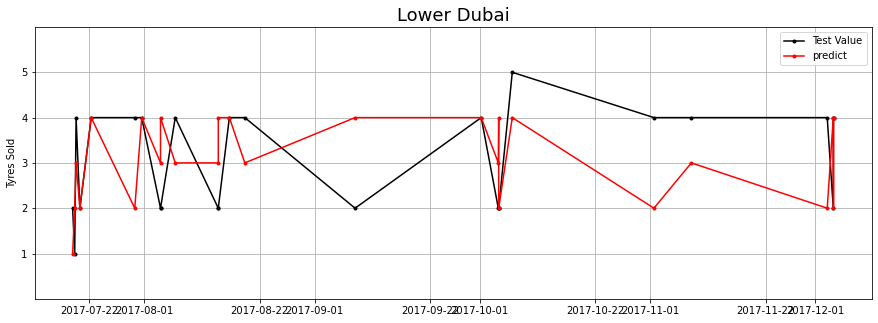

In [33]:
pitstop_AR(0.6, 0.2, l_dubai,'Lower Dubai')

20.0% or 32 rows will be used for testing.
will complete once it hits 72


The RMSE: 1.140175425099138
Accuracy Score: 0.0%


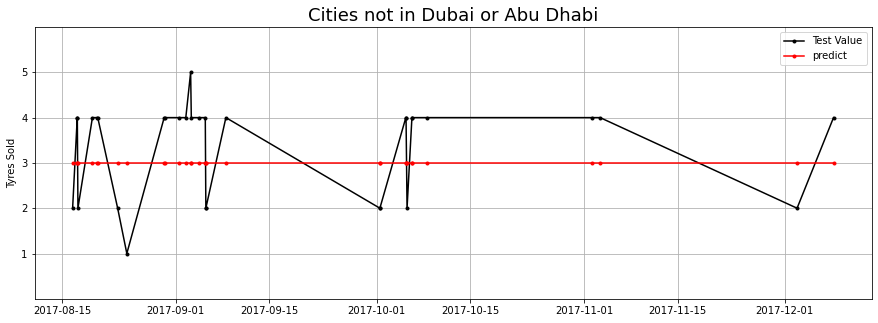

In [34]:
pitstop_AR(0.6,0.2,third_chunk, 'Cities not in Dubai or Abu Dhabi')

15.0% or 69 rows will be used for testing.
will complete once it hits 252


The RMSE: 1.0488088481701516
Accuracy Score: 8.57%


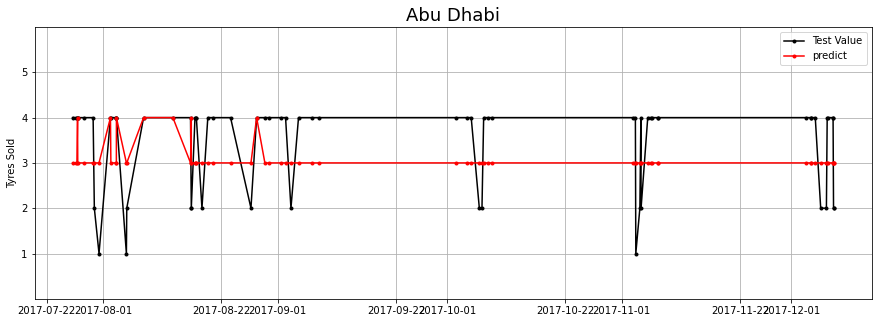

In [35]:
pitstop_AR(0.7,0.15,abu_dhabi,'Abu Dhabi')

15.0% or 276 rows will be used for testing.
will complete once it hits 1027


The RMSE: 1.4142135623730951
Accuracy Score: 21.66%


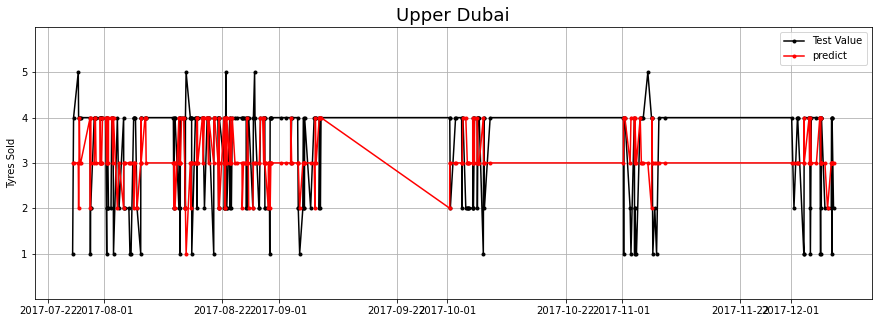

In [36]:
pitstop_AR(0.7,0.15,u_dubai, 'Upper Dubai')

You can see that the results aren't exaclt fantastic. More data is needed in order to increase accuracy. Some other techinques I could employ in the future: 

* Instead of individual days, have week by week entries
* Incorperate the other features to help the prediction

This has been the first iteration of the capstone!